## This notebook contains just the main implementation of the experiment. The latter demonstrates the opportunity of regular fully-connected layers to be substituted by so-called "CirLin" layers: linear layers with rectangular block circulant matrices of weights. The structure of the notebook is based on the article from the pytorch tutorial 
All the routine work is done in a separate file

In [2]:
%matplotlib inline

In [61]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [62]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images

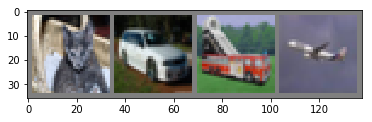

  cat   car truck plane


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [64]:
import math

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch._jit_internal import weak_module, weak_script_method

### The following two blocks are our source-code implementation of the CirCNN network without adressing convolutional layers

In [65]:
@weak_module
class CircLin(nn.Module):
    
    def __init__(self, in_features, out_features, block_size, bias=True):
        """
        q - in_blocks
        p - out_blocks
        k - block_size
        """
        super(CircLin, self).__init__()
        self.q = in_features // block_size
        self.p = out_features // block_size
        self.k = block_size
        self.weights = Parameter(torch.Tensor(self.p, self.q, self.k))
        self.o = Parameter(torch.zeros_like(self.weights,requires_grad=False))
        if bias:
            self.bias = Parameter(torch.Tensor(self.p,self.k))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        assert self.q
        assert self.p
        stdv = 1. / math.sqrt(self.weights.size(-1))
        self.weights.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
    @weak_script_method        
    def forward(self, input):
        def hadamard_simple(a,b):
            return torch.einsum("bqk,pqk->bpk",[a,b])
        def hadamard_complex(a,b):
            Re = hadamard_simple(a[...,0],b[...,0]) -\
                 hadamard_simple(a[...,1],b[...,1])
            Im = hadamard_simple(a[...,1],b[...,0]) +\
                 hadamard_simple(a[...,0],b[...,1])
            return torch.stack((Re,Im),-1)
        
        x = input.view(input.shape[0],-1,self.k)
        x = torch.stack((x,torch.zeros_like(x)),-1)
        dummy_weights = torch.stack((self.weights,self.o),-1)
        
        bias = torch.stack((self.bias,torch.zeros_like(self.bias)),-1)
        weights_freqs = torch.fft(dummy_weights,1)
        input_freqs = torch.fft(x,1)
        output = torch.ifft(hadamard_complex(input_freqs,weights_freqs),1)
        res = output + bias
        return res.view(res.shape[0],-1,2)[...,0]

In [66]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = CircLin(32 * 5 * 5, 120, 20)
        self.fc2 = CircLin(120, 90, 15)
        self.fc3 = CircLin(90, 10, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

net = Net()

Define a Loss function and optimizer  
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [67]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network  

In [68]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("You are on {}".format(device))
net = net.to(device)

You are on cuda:0


In [69]:
%%time
for epoch in range(2):  # loop over the dataset multiple times
    #net.train()
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.988
[1,  4000] loss: 1.737
[1,  6000] loss: 1.659
[1,  8000] loss: 1.595
[1, 10000] loss: 1.553
[1, 12000] loss: 1.551
[2,  2000] loss: 1.472
[2,  4000] loss: 1.470
[2,  6000] loss: 1.462
[2,  8000] loss: 1.436
[2, 10000] loss: 1.432
[2, 12000] loss: 1.429
Finished Training
Wall time: 13min 38s


Let us display an image from the test set to get familiar.

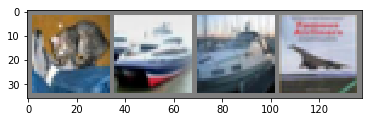

GroundTruth:    cat  ship  ship plane


In [77]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now let us see what the neural network thinks these examples above are:

In [71]:
net.to("cpu")
outputs = net(images)

The outputs are energies for the 10 classes.
Highest energy corresponds to the most probable class.
So, let's get the index of the highest energy:



In [72]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


The results are not bad.  
Let us look at how the network performs on the whole dataset.

In [73]:
correct = 0
total = 0
#net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [74]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 56 %
Accuracy of  bird : 45 %
Accuracy of   cat : 14 %
Accuracy of  deer : 33 %
Accuracy of   dog : 34 %
Accuracy of  frog : 63 %
Accuracy of horse : 69 %
Accuracy of  ship : 62 %
Accuracy of truck : 61 %


**The current network architecture deploys slightly wider convolution layers than it did when preparing the report, so the results in general are a little higher. However, they get worse on classes "cat","deer" and "dog".**

I'd like to thank Talgat for his mentoring and Temirlan for chosing this topic as